# Linear BMM with SAMBA toy models

This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

Author : Dan Liyanage 

Date : 19/21/2022

## Steps for linear BMM
    1. Get Models with a prediction method
    2. Choose a Mixing method 
    3. Estimate the mixture weights (parameters in the mixture function) with user defined calibration method
To execute each step in this notebook we need to import the following from Taweret.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../../Taweret'))


In [2]:
# Import models with a predict method
from Taweret.models import samba_models as toy_models
# Mixing object with a likelihood method
from Taweret.mix.linear import linear_mix as LM
# Wrapper for the likelihood to be used with Bilby
from Taweret.calibrate.likelihood_wrappers import likelihood_wrapper_for_bilby 

In [3]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For calibration
import bilby

# For other operations
import numpy as np
import os
import shutil

In [4]:
m1 = toy_models.loworder(2, 'informative')
m2 = toy_models.highorder(2, 'informative')
truth = toy_models.true_model()
exp = toy_models.exp_data()

In [5]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.predict(plot_g)
m2_prediction = m2.predict(plot_g)
true_output = truth.predict(plot_g)
exp_data= exp.predict(g)

In [6]:
exp_data

(array([2.44061423, 2.39590032, 2.29858531, 2.23260954, 2.1466104 ,
        2.0892655 , 2.00872534, 1.93344043, 1.87255364, 1.87554162]),
 array([0.02440614, 0.023959  , 0.02298585, 0.0223261 , 0.0214661 ,
        0.02089266, 0.02008725, 0.0193344 , 0.01872554, 0.01875542]))

# 1. The models and the experimental data.

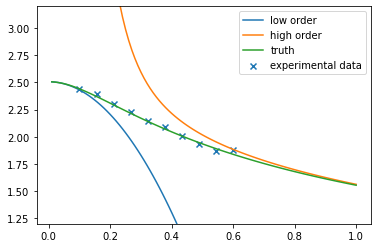

In [7]:
fig, ax_f = plt.subplots()
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g,exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

#  2. Choose a Mixing method

In [8]:
mix_model = LM(m1, m2, g, exp_data[0], exp_data[1], method='switchcos', n_mix=3)

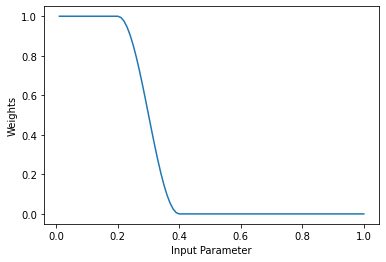

In [9]:
mix_model.plot_weights(np.array([0.2, 0.4, 0.3]),plot_g)

In [10]:
#mix_model.mix_loglikelihood_test([0.25])

In [11]:
mix_model.mix_loglikelihood(np.array([0.2, 0.4, 0.3]))

5.96984761399272

### BMM model output corresponding to the above input weights 

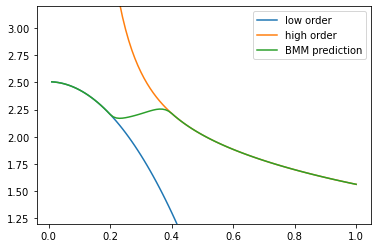

In [12]:
fig, ax = plt.subplots()
mix_prediction = mix_model.prediction(np.array([0.2, 0.4, 0.3]),plot_g)
ax.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax.plot(plot_g, mix_prediction.flatten(), label='BMM prediction')
ax.set_ylim(1.2,3.2)
ax.legend()

### Log likelihood of the mixed model as a function of the Step mixing function parameter

In [13]:
# sw = np.linspace(0.01,1,1000)
# likelihood = np.array([mix_model.mix_loglikelihood(np.array([s])) for s in sw]).flatten()
# fig, ax = plt.subplots()
# ax.plot(sw,likelihood,label='Mixture likelihood for step function')

# 3. Estimating the mixture weights

### Wrap the likelihood function in the mixed model to be calibrated

In [14]:
likelihood = likelihood_wrapper_for_bilby(mix_model)

### Get posterior samples using Bilby

Need to speceify a constained prior for switchcos. g1 < g3 < g2
We follow Bilby documentation on how to specefy a prior with constraints
https://lscsoft.docs.ligo.org/bilby/prior.html#prior-constraints

In [15]:
def convert_x_y_to_z(parameters):
    """
    Function to convert between sampled parameters and constraint parameter.

    Parameters
    ----------
    parameters: dict
        Dictionary containing sampled parameter values, 'theta_0', 'theta_1', 'theta_2'.

    Returns
    -------
    dict: Dictionary with constraint parameter 'z_0, z_1' added.
    """
    converted_parameters = parameters.copy()
    converted_parameters['z_0'] = parameters['theta_2'] - parameters['theta_0']
    converted_parameters['z_1'] = parameters['theta_1'] - parameters['theta_2']
    return converted_parameters

In [16]:
from bilby.core.prior import PriorDict, Uniform, Constraint, TruncatedNormal

priors = PriorDict(conversion_function=convert_x_y_to_z)
# priors['theta_0'] = Uniform(minimum=0.0, maximum=0.3)
# priors['theta_1'] = Uniform(minimum=0.0, maximum=0.55)
# priors['theta_2'] = Uniform(minimum=0.0, maximum=0.8)

priors['theta_0'] = TruncatedNormal(0.1, 0.05, 0.01, 0.3)
priors['theta_1'] = TruncatedNormal(0.6, 0.05, 0, 0.8)
priors['theta_2'] = TruncatedNormal(0.4, 0.05, 0, 0.55)
priors['z_0'] = Constraint(minimum=0, maximum=1)
priors['z_1'] = Constraint(minimum=0, maximum=1)

08:57 bilby INFO    : Running for label 'switchcos_mixing', output will be saved to 'outdir'
08:57 bilby INFO    : Search parameters:
08:57 bilby INFO    :   theta_0 = TruncatedNormal(mu=0.1, sigma=0.05, minimum=0.01, maximum=0.3, name=None, latex_label=None, unit=None, boundary=None)
08:57 bilby INFO    :   theta_1 = TruncatedNormal(mu=0.6, sigma=0.05, minimum=0, maximum=0.8, name=None, latex_label=None, unit=None, boundary=None)
08:57 bilby INFO    :   theta_2 = TruncatedNormal(mu=0.4, sigma=0.05, minimum=0, maximum=0.55, name=None, latex_label=None, unit=None, boundary=None)
08:57 bilby INFO    :   z_0 = Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None)
08:57 bilby INFO    :   z_1 = Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None)
08:57 bilby INFO    : Single likelihood evaluation took 2.414e-04 s
08:57 bilby WARNING : Supplied argument 'npool' not an argument of 'Ptemcee', removing.
08:57 bilby WARNING : Supplied argument 'nburn' not a

1|0:00:00|nc:1.0e+03|a0:0.20-1.00|swp:0.86-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
2|0:00:00|nc:2.0e+03|a0:0.40-0.90|swp:0.87-0.99|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
3|0:00:00|nc:3.0e+03|a0:0.40-0.87|swp:0.88-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.09ms/ev
4|0:00:00|nc:4.0e+03|a0:0.50-0.85|swp:0.89-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.08ms/ev
5|0:00:00|nc:5.0e+03|a0:0.48-0.84|swp:0.88-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
6|0:00:00|nc:6.0e+03|a0:0.53-0.83|swp:0.88-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.11ms/ev
7|0:00:00|nc:7.0e+03|a0:0.54-0.83|swp:0.88-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.12ms/ev
8|0:00:00|nc:8.0e+03|a0:0.55-0.82|swp:0.89-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.11ms/ev
9|0:00:00|nc:9.0e+03|a0:0.53-0.80|swp:0.89-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.11ms/ev
10|0:00:01|nc:1.0e+04|a0:0.56-0.80|swp:0.89-1.00|n:nan<3000|t!nan(+nan,+nan)|q:inf|0.11ms/ev
11|0:00:01|nc:1.1e+04|a0:0.56-0.78|swp:0.89-1.00|n:nan<3000|t!nan(+nan,+nan)|q:

08:58 bilby INFO    : Finished sampling
08:58 bilby INFO    : Writing checkpoint and diagnostics
08:58 bilby INFO    : Finished writing checkpoint
08:58 bilby INFO    : Sampling time: 0:01:38.383994
08:58 bilby INFO    : Summary of results:
nsamples: 3020
ln_noise_evidence:    nan
ln_evidence:  4.700 +/-  0.031
ln_bayes_factor:    nan +/-  0.031



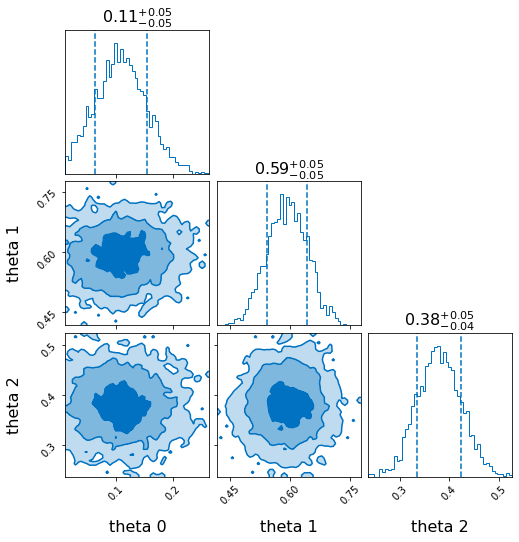

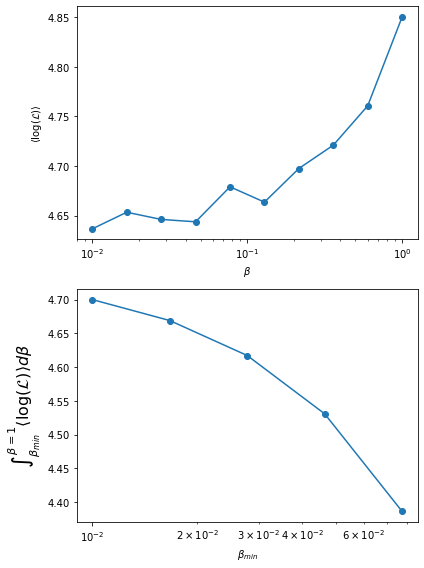

In [17]:
# A few simple setup steps
label = "switchcos_mixing"
outdir = "outdir"

priors = priors

# priors = dict(
#     theta_0=bilby.core.prior.Beta(2,2)
# )

# And run sampler
## If file exists, delete it ##
if os.path.exists(f'{outdir}/{label}_result.json'):
    os.remove(f'{outdir}/{label}_result.json')
    os.remove(f'{outdir}/{label}_checkpoint_resume.pickle')
    os.remove(f'{outdir}/{label}_samples.txt')
    #shutil.rmtree(outdir)
result = bilby.run_sampler(
    likelihood,
    priors,
    label=label,
    outdir=outdir,
    sampler="ptemcee",
    ntemps=10,
    nwalkers=20,
    Tmax=100,
    nburn=200,
    nsamples=3000,  # This is the number of raw samples
    threads=5,
    )
result.plot_corner()


In [18]:
result.posterior

theta_0   theta_1   theta_2  log_likelihood  log_prior
0     0.158590  0.619320  0.401275        4.761472   5.508453
1     0.084796  0.641240  0.396366        4.590756   5.880974
2     0.170293  0.560827  0.317692        5.475379   3.619932
3     0.125549  0.554161  0.350557        5.288407   5.230277
4     0.165608  0.685691  0.490202        3.311155   2.313251
...        ...       ...       ...             ...        ...
3015  0.141508  0.554943  0.377637        5.165188   5.419361
3016  0.142440  0.666660  0.371631        4.811714   4.860087
3017  0.162773  0.593333  0.337088        5.298368   4.681432
3018  0.143119  0.612936  0.351010        5.125509   5.384681
3019  0.134180  0.654876  0.324948        5.041060   4.307491

[3020 rows x 5 columns]

In [19]:
mix_model.mix_loglikelihood(np.array([0.2, 0.4, 0.3]))

5.96984761399272

In [20]:
mix_model.mix_loglikelihood(result.posterior.values[0,0:3])

4.761472070802143

In [21]:
result.posterior['log_likelihood'].values

array([4.76147207, 4.59075584, 5.47537936, ..., 5.29836751, 5.12550927,
       5.04105956])

In [22]:
n_max = np.argmax(result.posterior['log_likelihood'].values)
print(n_max)
print(result.posterior.values[n_max,3])

783
5.749830132623979


In [23]:
MAP_value = result.posterior.values[n_max,0:3]
print(MAP_value)
print()

[0.19703712 0.4962965  0.31835116]



In [24]:
# If false, do not try to find the MAP value and load it from a saved file.
find_map_param = True
from scipy import optimize
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip([0,0,0],[1,1,1])]
    print(bounds)
    x0 = [a+b/2 for a,b in bounds]
    rslt = optimize.differential_evolution(lambda x: -mix_model.mix_loglikelihood(x) if x[0]<x[2] and x[1]>x[2] else 1000,
                                           bounds=bounds,
                                          maxiter=100000,
                                           tol=1e-15,
                                           disp=True)
    # minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds,"tol":1e-15}
    # rslt=optimize.basinhopping(lambda x: -mix_model.mix_loglikelihood(x) if x[0]<x[2] and x[1]>x[2] else 1000
    #                             ,x0,niter=1000,minimizer_kwargs=minimizer_kwargs)
    map_values = rslt.x
    np.save(f'{outdir}/{label}', map_values)
else:
    map_values = np.load(f'{outdir}/{label}'+'.npy')
print(map_values)

[(0, 1), (0, 1), (0, 1)]
differential_evolution step 1: f(x)= -6.07212
differential_evolution step 2: f(x)= -6.07212
differential_evolution step 3: f(x)= -6.07212
differential_evolution step 4: f(x)= -6.09816
differential_evolution step 5: f(x)= -6.2325
differential_evolution step 6: f(x)= -6.2325
differential_evolution step 7: f(x)= -6.2325
differential_evolution step 8: f(x)= -6.2325
differential_evolution step 9: f(x)= -6.2325
differential_evolution step 10: f(x)= -6.2325
differential_evolution step 11: f(x)= -6.2325
differential_evolution step 12: f(x)= -6.2325
differential_evolution step 13: f(x)= -6.2325
differential_evolution step 14: f(x)= -6.2325
differential_evolution step 15: f(x)= -6.2325
differential_evolution step 16: f(x)= -6.2325
differential_evolution step 17: f(x)= -6.2325
differential_evolution step 18: f(x)= -6.2325
differential_evolution step 19: f(x)= -6.2325
differential_evolution step 20: f(x)= -6.2325
differential_evolution step 21: f(x)= -6.2325
differential_e

### trace plots

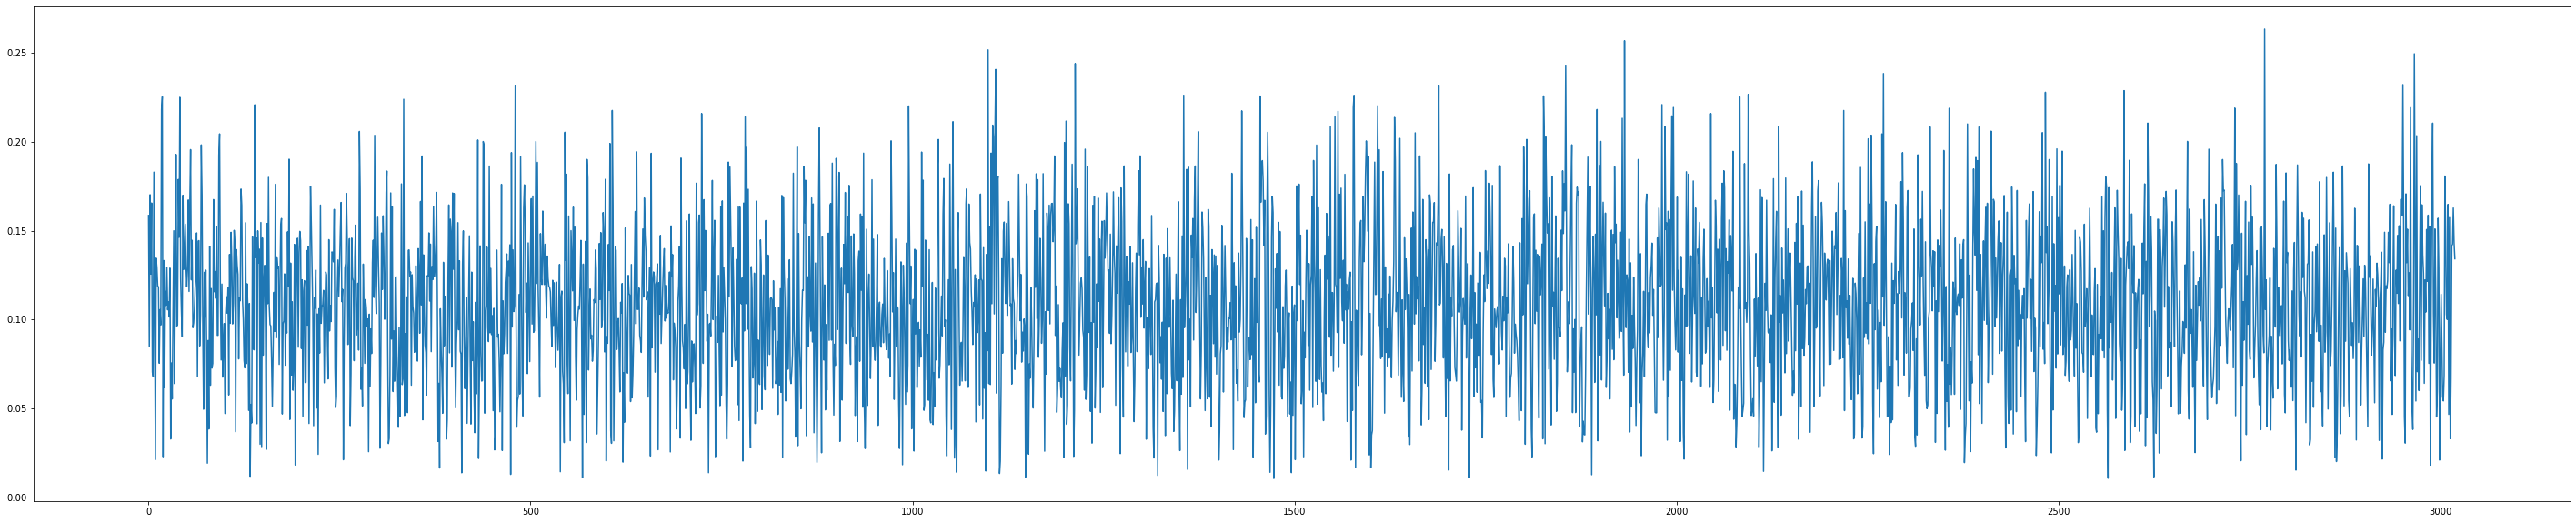

In [25]:

#sns.set_context(font_scale=100)
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(result.posterior['theta_0'].values)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.legend()
#ax.plot(plot_g, true_output[0], label='truth')
#ax.set_ylim(1.2,3.2)

### Predictions for the mixed model with posterior weights

In [34]:
result.posterior.values.shape

(3020, 5)

In [36]:
pos_predictions = []
for sample in result.posterior.values[:,0:3]:
    mean = mix_model.prediction(np.array([sample]).flatten(),plot_g)
    pos_predictions.append(mean)
pos_predictions = np.array(pos_predictions).reshape(-1,len(plot_g))

In [37]:
pos_predictions.shape

(3020, 100)

In [38]:
per0,per5,per20,per80,per95,per100=np.percentile(pos_predictions,[0,5,20,80,95,100], axis=0)

(1.2, 3.2)

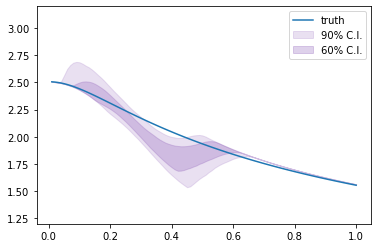

In [39]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.plot(plot_g, true_output[0], label='truth')
ax.legend()
ax.set_ylim(1.2,3.2)